In [ ]:
import torch
import torch.nn.functional as f
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torchsummary import summary
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# Train data transformation

train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                                       ])
                                       

# Test transform

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.1307,), std=(0.3081,))
                                      ])

Dataset and creating Train/Test split

In [ ]:
train = datasets.MNIST(root='../data', train=True, download=True, transform=train_transforms)

test = datasets.MNIST(root='../data', train=False, download=True, transform=test_transforms)

Dataloader arguments and train test dataloaders

In [ ]:
torch.manual_seed(100)

In [ ]:
cuda = torch.cuda.is_available()

if cuda:
  print('\n CUDA is available')
  torch.cuda.manual_seed(100)
else:
  print("\n No GPU")

  


 CUDA is available


In [ ]:
WORKERS = 2
BATCH_SIZE = 64

In [ ]:
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=WORKERS, pin_memory=True) if cuda\
 else dict(shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
# train dataloader 

train_loader = torch.utils.data.DataLoader(dataset=train, **dataloader_args)


# test dataloader

test_loader = torch.utils.data.DataLoader(dataset=test, **dataloader_args)

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

In [ ]:

def train(model, device, train_loader, optimizer, epochs=1, scheduler=None, test=False, test_loader=None, reset=None):
    if test and not test_loader:
        raise ValueError("`test`= True but `test_loader` not provided")
    if reset:
      for i in reset:
          if i:
              i = []
          
    model.train()
    for epoch in range(epochs):
      correct = 0
      processed = 0
      train_loss = 0
      print(f"\n\nepoch: {epoch+1}")
      pbar = tqdm(train_loader)
      for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model(data)
          loss = f.nll_loss(output, target)
          train_loss += loss.item()
          loss.backward()
          optimizer.step()
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
          processed += len(data)
      acc = 100 * correct/processed
      train_losses.append(train_loss)
      train_accuracy.append(acc)
      pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
      
      if scheduler:
          print(f'lr: {scheduler.get_last_lr()[0]}')
          scheduler.step()
      
      train_loss /= len(train_loader.dataset)
      print('\nTrain set:                              Accuracy: {}/{} ({:.6f}%)'.format(correct, len(train_loader.dataset), 100.0 * correct / len(train_loader.dataset)))

      if test:
          model.eval()
          test_loss = 0
          correct = 0
          with torch.no_grad():
              for data, target in test_loader:
                  data, target = data.to(device), target.to(device)
                  output = model(data)
                  test_loss += f.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  correct += pred.eq(target.view_as(pred)).sum().item()

          test_loss /= len(test_loader.dataset)
          test_losses.append(test_loss)
          test_accuracy.append(100. * correct / len(test_loader.dataset))

          print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))

## CODE 2

After seeing not a good gap between the two accuracies and the test accuracy dropping below 99.0% in later epochs, here I try to add Batch Normalization to see of making all the weak edges and gradients for MNIST (1x28x28) will make things better for the network in terms of test accuracy and add Dropout for bridging the gap simultaneously.

In [ ]:
class Net1(nn.Module):        
    def __init__(self):
        super(Net1, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=26, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(26),
            nn.ReLU()
        ) # output_size = 24
        
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        
        self.convblock3 = nn.Sequential( # mixing channel information here to re-create information into 16 channels
            nn.Conv2d(in_channels=26, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 12

        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 10

        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU()
        ) 
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) 

        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        ) 
        
        self.dropout = nn.Dropout2d(0.05)
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.dropout(x)
        x = self.convblock2(x)
        x = self.dropout(x)
        x = self.pool1(x) # since it's MNIST and 1x28x28 images, 7x7 makes little sense for such small image dataset to get related features, so starting network itself contains maxpool at 5x5 RF
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.convblock4(x)
        x = self.dropout(x)
        x = self.convblock5(x)
        x = self.dropout(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.dropout(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return f.log_softmax(x, dim=-1)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net1().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         Dropout2d-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 26, 26, 26]           3,744
       BatchNorm2d-6           [-1, 26, 26, 26]              52
              ReLU-7           [-1, 26, 26, 26]               0
         Dropout2d-8           [-1, 26, 26, 26]               0
         MaxPool2d-9           [-1, 26, 13, 13]               0
           Conv2d-10           [-1, 16, 13, 13]             416
      BatchNorm2d-11           [-1, 16, 13, 13]              32
             ReLU-12           [-1, 16, 13, 13]               0
        Dropout2d-13           [-1, 16, 13, 13]               0
           Conv2d-14           [-1, 20,

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
train(model, device, train_loader, optimizer, epochs=15, scheduler=None, test=True, test_loader=test_loader, reset = [train_losses, test_losses, train_accuracy, test_accuracy])

  0%|          | 0/938 [00:00<?, ?it/s]



epoch: 1


100%|██████████| 938/938 [00:24<00:00, 38.85it/s]


Train set:                              Accuracy: 55608/60000 (92.680000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9859/10000 (98.590000%)



epoch: 2


100%|██████████| 938/938 [00:22<00:00, 42.03it/s]


Train set:                              Accuracy: 58814/60000 (98.023333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9886/10000 (98.860000%)



epoch: 3


100%|██████████| 938/938 [00:22<00:00, 42.44it/s]


Train set:                              Accuracy: 59188/60000 (98.646667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9901/10000 (99.010000%)



epoch: 4


100%|██████████| 938/938 [00:22<00:00, 42.07it/s]


Train set:                              Accuracy: 59327/60000 (98.878333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9921/10000 (99.210000%)



epoch: 5


100%|██████████| 938/938 [00:22<00:00, 41.54it/s]


Train set:                              Accuracy: 59414/60000 (99.023333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9927/10000 (99.270000%)



epoch: 6


100%|██████████| 938/938 [00:22<00:00, 41.54it/s]


Train set:                              Accuracy: 59496/60000 (99.160000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9913/10000 (99.130000%)



epoch: 7


100%|██████████| 938/938 [00:22<00:00, 41.97it/s]


Train set:                              Accuracy: 59547/60000 (99.245000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9930/10000 (99.300000%)



epoch: 8


100%|██████████| 938/938 [00:22<00:00, 42.30it/s]


Train set:                              Accuracy: 59600/60000 (99.333333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9918/10000 (99.180000%)



epoch: 9


100%|██████████| 938/938 [00:22<00:00, 42.54it/s]


Train set:                              Accuracy: 59633/60000 (99.388333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9923/10000 (99.230000%)



epoch: 10


100%|██████████| 938/938 [00:22<00:00, 41.86it/s]


Train set:                              Accuracy: 59643/60000 (99.405000%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9904/10000 (99.040000%)



epoch: 11


100%|██████████| 938/938 [00:22<00:00, 41.88it/s]


Train set:                              Accuracy: 59717/60000 (99.528333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9917/10000 (99.170000%)



epoch: 12


100%|██████████| 938/938 [00:22<00:00, 41.66it/s]


Train set:                              Accuracy: 59728/60000 (99.546667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9930/10000 (99.300000%)



epoch: 13


100%|██████████| 938/938 [00:22<00:00, 41.44it/s]


Train set:                              Accuracy: 59752/60000 (99.586667%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9932/10000 (99.320000%)



epoch: 14


100%|██████████| 938/938 [00:22<00:00, 41.42it/s]


Train set:                              Accuracy: 59759/60000 (99.598333%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9913/10000 (99.130000%)



epoch: 15


100%|██████████| 938/938 [00:22<00:00, 41.88it/s]


Train set:                              Accuracy: 59819/60000 (99.698333%)



Test set: Average loss: 0.0293, Accuracy: 9925/10000 (99.250000%)



### The above network looks promising after BN and DO. Need to experiment more.

Text(0.5, 1.0, 'Test Accuracy')

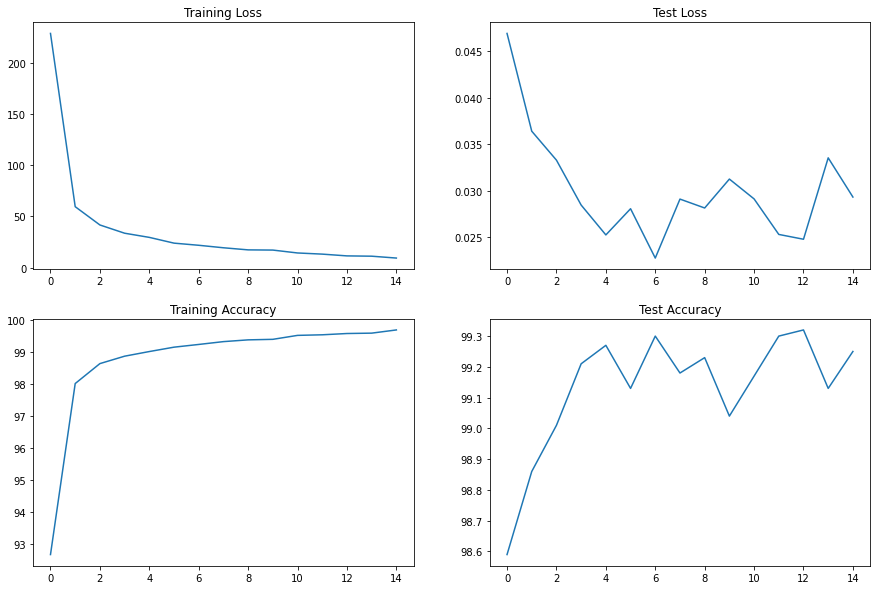

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")

# Analysis

>Interestingly, after adding Batch Normalization, not only did the test accuracy crossed 99% and touched 99.29% in final epoch, the train accuracy increased simultaneously to 99.69%. Which implies that BatchNormalization actually helped edges and gradients to become more prominent before being fed into next layers. 

>However, the gap is still considerable and now the model seems to over fit a little. Because 99.69% is a good accuracy but test data set has a difference of around 0.40% .

> I guess larger dropout value should be used to bridge that gap between accuracies further.
